# Negative after-tax income

This notebook analyzes tax units with negative after-tax income, in the way that [this notebook](http://nbviewer.jupyter.org/github/MaxGhenis/taxcalc-notebooks/blob/master/exploratory/negative_expanded_income.ipynb) considers negative expanded income. It quotes and addresses some questions from @martinholmer about expanded income, but all results concern after-tax income.

Using `taxcalc` 0.16.1, this analysis includes total value of benefits programs.

*Data: CPS  |  Tax year: 2018  |  Type: Static  |  Author: Max Ghenis  |  Date run: 2018-02-22*

## Setup

In [1]:
import taxcalc as tc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'0.16.1'

In [3]:
sns.set_style('white')
DPI = 300
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi']= DPI

In [4]:
recs = tc.Records.cps_constructor()
calc = tc.Calculator(records=recs, policy=tc.Policy())
calc.advance_to_year(2018)
calc.calc_all()

You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.


Create `DataFrame` of the items desired.

Which relevant columns are available? Totals, but really just care about != 0.

In [5]:
df = calc.dataframe(['s006',  # Weight. 
                     'aftertax_income'
                    ])
df.head()

,s006,aftertax_income
0,239.46,42287.547869
1,202.59,20461.070670
2,255.35,96222.033747
3,178.36,26597.379609
4,270.80,41631.335096


## Preprocessing

Add weight normalized to sum to 100, to simplify percentile calculations.

In [6]:
df['weight'] = 100 * df['s006'] / df['s006'].sum()

Add after-tax income percentile by sorting and summing `cumsum` of normalized weight.

In [7]:
df.sort_values(by=['aftertax_income'], inplace=True)
df['aftertax_income_percentile'] = df['weight'].cumsum()
df['aftertax_income_s006_cumsum'] = df['s006'].cumsum()

Add flag for whether after-tax income is negative, zero, or positive. 

In [8]:
df['aftertax_income_sign'] = np.where(df['aftertax_income'] < 0, 'Negative', 
                                      np.where(df['aftertax_income'] > 0, 'Positive', 'Zero'))

## Analysis

### Examination

In [9]:
df.head()

,s006,aftertax_income,weight,aftertax_income_percentile,aftertax_income_s006_cumsum,aftertax_income_sign
37355,60.49,-3.555567e+06,0.000036,0.000036,60.49,Negative
394742,499.17,-9.314900e+05,0.000294,0.000329,559.66,Negative
29539,1209.73,-8.047257e+05,0.000712,0.001041,1769.39,Negative
276823,476.72,-7.817199e+05,0.000281,0.001322,2246.11,Negative
306673,399.35,-7.776941e+05,0.000235,0.001557,2645.46,Negative


Examine record with most negative after-tax income.

In [10]:
df[df['aftertax_income'] == df['aftertax_income'].min()]

,s006,aftertax_income,weight,aftertax_income_percentile,aftertax_income_s006_cumsum,aftertax_income_sign
37355,60.49,-3.555567e+06,0.000036,0.000036,60.49,Negative


### Zero after-tax income

> What fraction (using sample weights) of the bottom decile has zero expanded income?

Per below pivot table, 0.73%, or 7.3% of the bottom decile.

In [11]:
pd.pivot_table(df, values='weight', index=['aftertax_income_sign'],
               aggfunc=np.sum, margins=True).round(2)

,weight
aftertax_income_sign,
Negative,0.12
Positive,99.15
Zero,0.73
All,100.00


### Negative after-tax income

> What fraction of the bottom decile has negative expanded income?

Per above pivot table, 0.12% of total tax units, or 1.2% of the bottom decile.

In [12]:
neg_afti = df[df['aftertax_income'] < 0].sort_values(by=['aftertax_income'])

Aggregate after-tax income of tax units with negative after-tax income.

In [13]:
agg_neg_afti = (neg_afti['aftertax_income'] * neg_afti['s006']).sum()
neg_afti_per_unit = agg_neg_afti / neg_afti['s006'].sum()
print 'Tax units with negative after-tax income have a total after-tax income of -${:.1f}B'.format(
    -agg_neg_afti / 1e9)
print 'This is an average of -${:,.0f} per tax unit.'.format(-neg_afti_per_unit)

Tax units with negative after-tax income have a total after-tax income of -$26.5B
This is an average of -$134,030 per tax unit.


CDF.

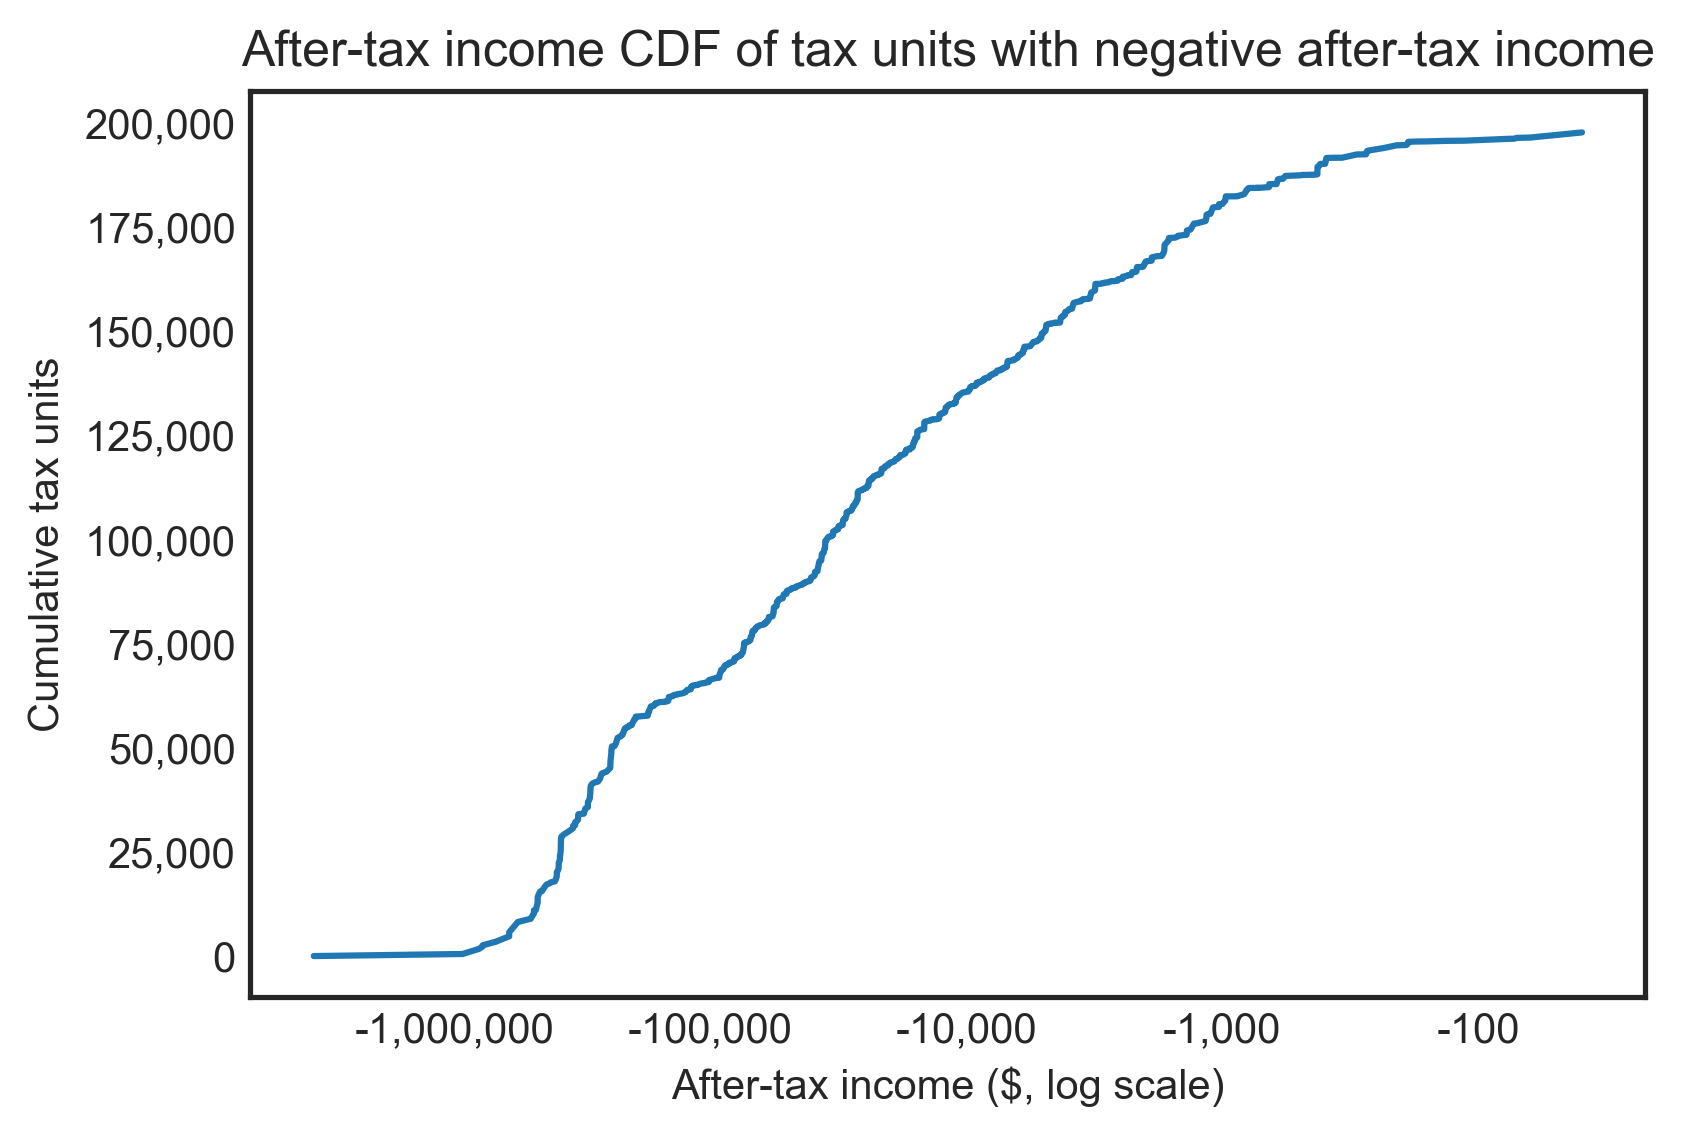

In [14]:
f, ax = plt.subplots()

line, = ax.plot(neg_afti['aftertax_income'], neg_afti['aftertax_income_s006_cumsum'])

plt.xscale('symlog')

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(
    lambda x, loc: "{:,}".format(int(x))))

ax.get_xaxis().set_major_formatter(plt.FuncFormatter(
    lambda x, loc: "{:,}".format(int(x))))

ax.set(xlabel='After-tax income ($, log scale)', ylabel='Cumulative tax units', 
       title='After-tax income CDF of tax units with negative after-tax income')

plt.show()

### Bottom decile with positive after-tax income

> What fraction of the bottom decile has positive expanded income?

Per pivot table above, 91.5% of the bottom decile has positive after-tax income.

> What is the aggregate expanded income of this subgroup?

In [15]:
bd_pos_afti = df[(df['aftertax_income'] > 0) & (df['aftertax_income_percentile'] <= 10)]

In [16]:
agg_bd_pos_afti = (bd_pos_afti['aftertax_income'] * bd_pos_afti['s006']).sum()
bd_pos_afti_per_unit = agg_bd_pos_afti / bd_pos_afti['s006'].sum()
print 'Bottom-decile tax units with positive after-tax income have a total after-tax income of ${:.1f}B'.format(
    agg_bd_pos_afti / 1e9)
print 'This is an average of ${:,.0f} per tax unit.'.format(bd_pos_afti_per_unit)

Bottom-decile tax units with positive after-tax income have a total after-tax income of $89.7B
This is an average of $5,769 per tax unit.


% that negative after-tax income units reduce bottom-quintile by.

In [17]:
bd_total = df[df['aftertax_income_percentile'] <= 10]
1 - (bd_total['aftertax_income'] * bd_total['s006']).sum() / agg_bd_pos_afti

0.29536724190780705

## Effect on bottom quintile

How do negative after-tax units affect bottom quintile summaries?

In [18]:
bq_pos_afti = df[(df['aftertax_income'] > 0) & (df['aftertax_income_percentile'] <= 20)]

In [19]:
agg_bq_pos_afti = (bq_pos_afti['aftertax_income'] * bq_pos_afti['s006']).sum()
bq_pos_afti_per_unit = agg_bq_pos_afti / bq_pos_afti['s006'].sum()
print 'Bottom-quintile tax units with positive after-tax income have a total after-tax income of ${:.1f}B'.format(
    agg_bq_pos_afti / 1e9)
print 'This is an average of ${:,.0f} per tax unit.'.format(bq_pos_afti_per_unit)

Bottom-quintile tax units with positive after-tax income have a total after-tax income of $377.8B
This is an average of $11,611 per tax unit.


% that negative after-tax income units reduce bottom-quintile by.

In [20]:
bq_total = df[df['aftertax_income_percentile'] <= 20]
1 - (bq_total['aftertax_income'] * bq_total['s006']).sum() / agg_bq_pos_afti

0.070112376211764249